# Installs and Imports

# Installs and Imports

In [1]:
!pip install pandas scipy openpyxl
!pip install pyMechkar
!pip install lifelines
!pip install sweetviz
!pip install imbalanced-learn
!pip install "numpy>=1.21,<1.25"

import pandas as pd
import sweetviz as sv
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pyMechkar.analysis import Table1
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.11/dist-packages/pyMechkar/exploreData.py:45: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na',True)
/usr/local/lib/python3.11/dist-packages/pyMechkar/analysis.py:65: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na',True)


# Data Preparation - Delete CL

In [2]:
# Load the original dataset
df = pd.read_csv("cirrhosis.csv")

# Remove records from the CL group only
df = df[df['Status'] != 'CL']

# Save the new dataset for future work
df.to_csv("cirrhosis_no_CL.csv", index=False)

In [3]:
# ==============================================
# Basic summary before Sweetviz
# ==============================================
print(df.info())
print(df.describe())
sns.countplot(x='Status', data=df)

<class 'pandas.core.frame.DataFrame'>
Index: 393 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             393 non-null    int64  
 1   N_Days         393 non-null    int64  
 2   Status         393 non-null    object 
 3   Drug           293 non-null    object 
 4   Age            393 non-null    int64  
 5   Sex            393 non-null    object 
 6   Ascites        293 non-null    object 
 7   Hepatomegaly   293 non-null    object 
 8   Spiders        293 non-null    object 
 9   Edema          393 non-null    object 
 10  Bilirubin      393 non-null    float64
 11  Cholesterol    266 non-null    float64
 12  Albumin        393 non-null    float64
 13  Copper         291 non-null    float64
 14  Alk_Phos       293 non-null    float64
 15  SGOT           293 non-null    float64
 16  Tryglicerides  264 non-null    float64
 17  Platelets      382 non-null    float64
 18  Prothrombin    

<Axes: xlabel='Status', ylabel='count'>

In [4]:
# ==============================================
# Section 4.1.1 – Exploratory Data Analysis (EDA) with Sweetviz
# ==============================================
df = pd.read_csv("cirrhosis_no_CL.csv")

# Create a report using the cleaned dataset
report = sv.analyze(df)

# Save the report to an HTML file
report.show_html("sweetviz_report.html", open_browser=True)

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [5]:
# ==============================================
# Functions for EDA
# ==============================================

def plot_histogram(data, column, title=None):
    plt.figure(figsize=(6, 4))
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f"Distribution of {title or column}")
    plt.xlabel(title or column)
    plt.ylabel("Frequency")
    plt.show()

def plot_boxplot(data, x_col, y_col, title=None):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=x_col, y=y_col, data=data)
    plt.title(title or f"{y_col} by {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

def plot_correlation_heatmap(data, columns=None, exclude_cols=None, title="Correlation Heatmap"):
    if columns:
        corr_data = data[columns]
    else:
        corr_data = data.select_dtypes(include='number')
        if exclude_cols:
            corr_data = corr_data.drop(columns=exclude_cols, errors='ignore')
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_missing_matrix(data):
    msno.matrix(data)


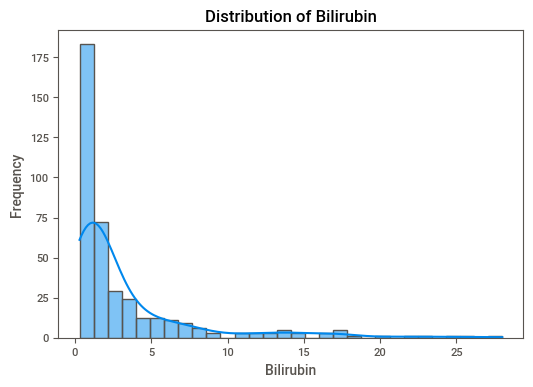

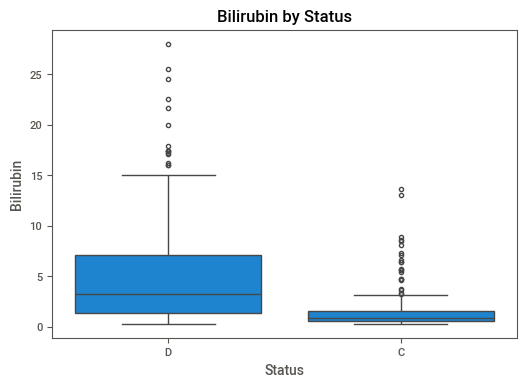

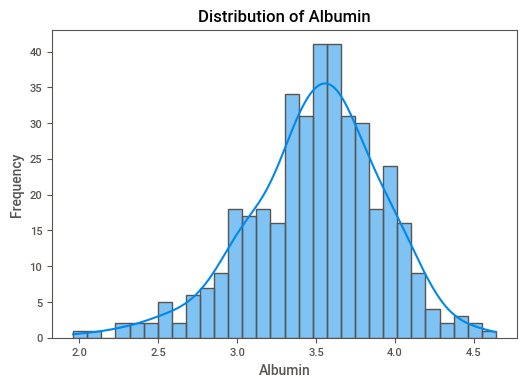

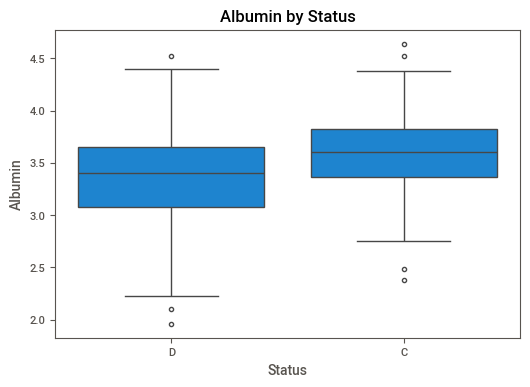

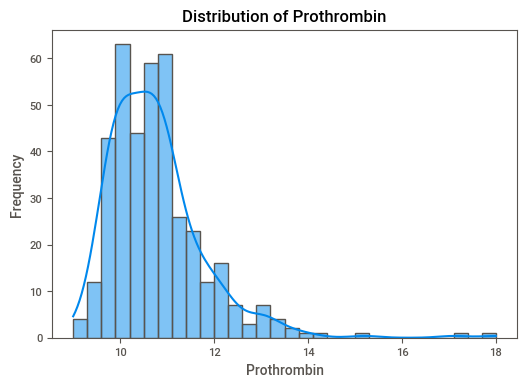

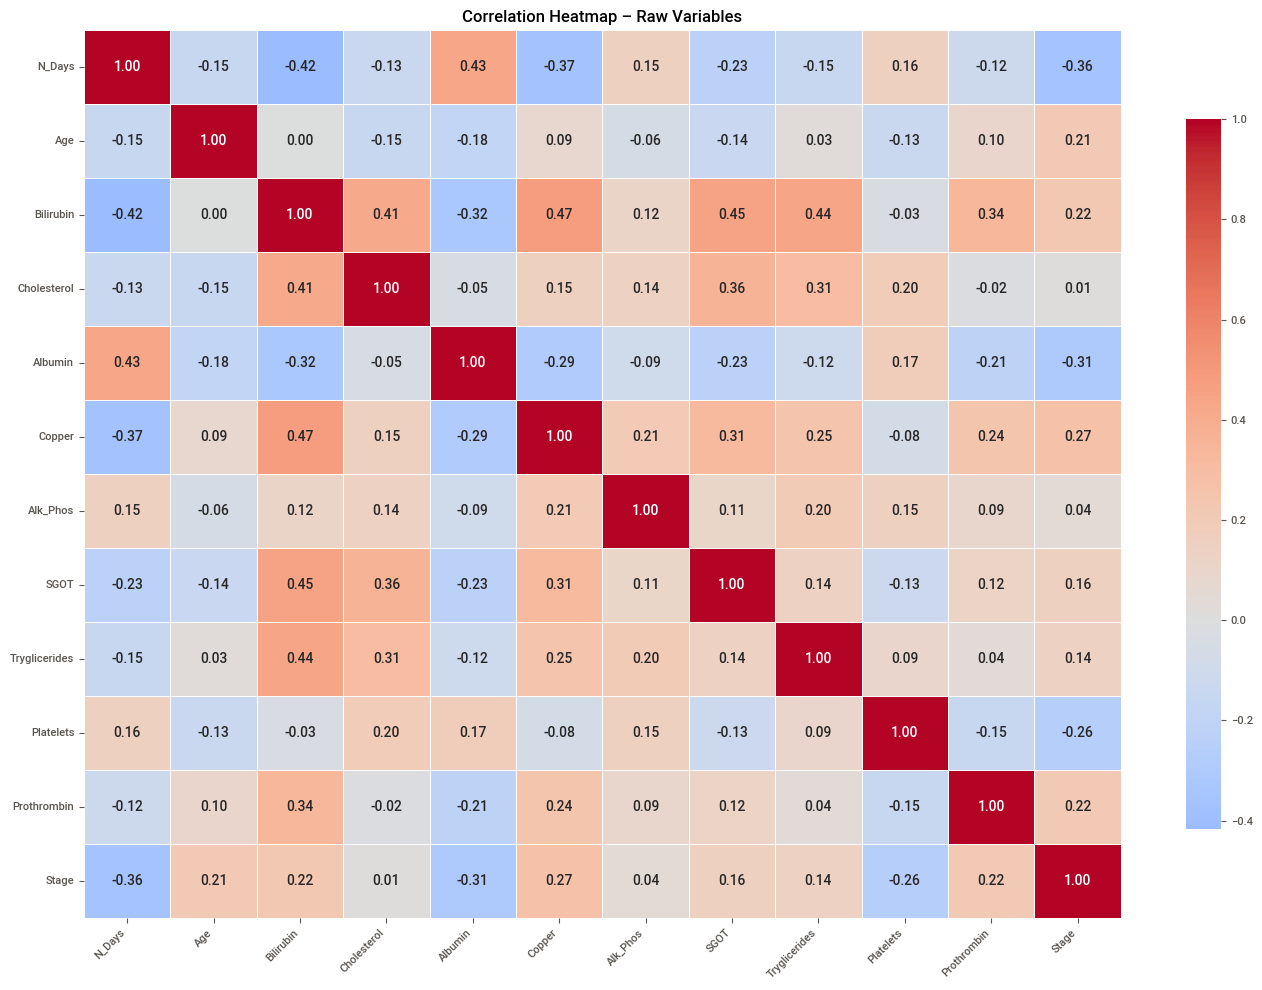

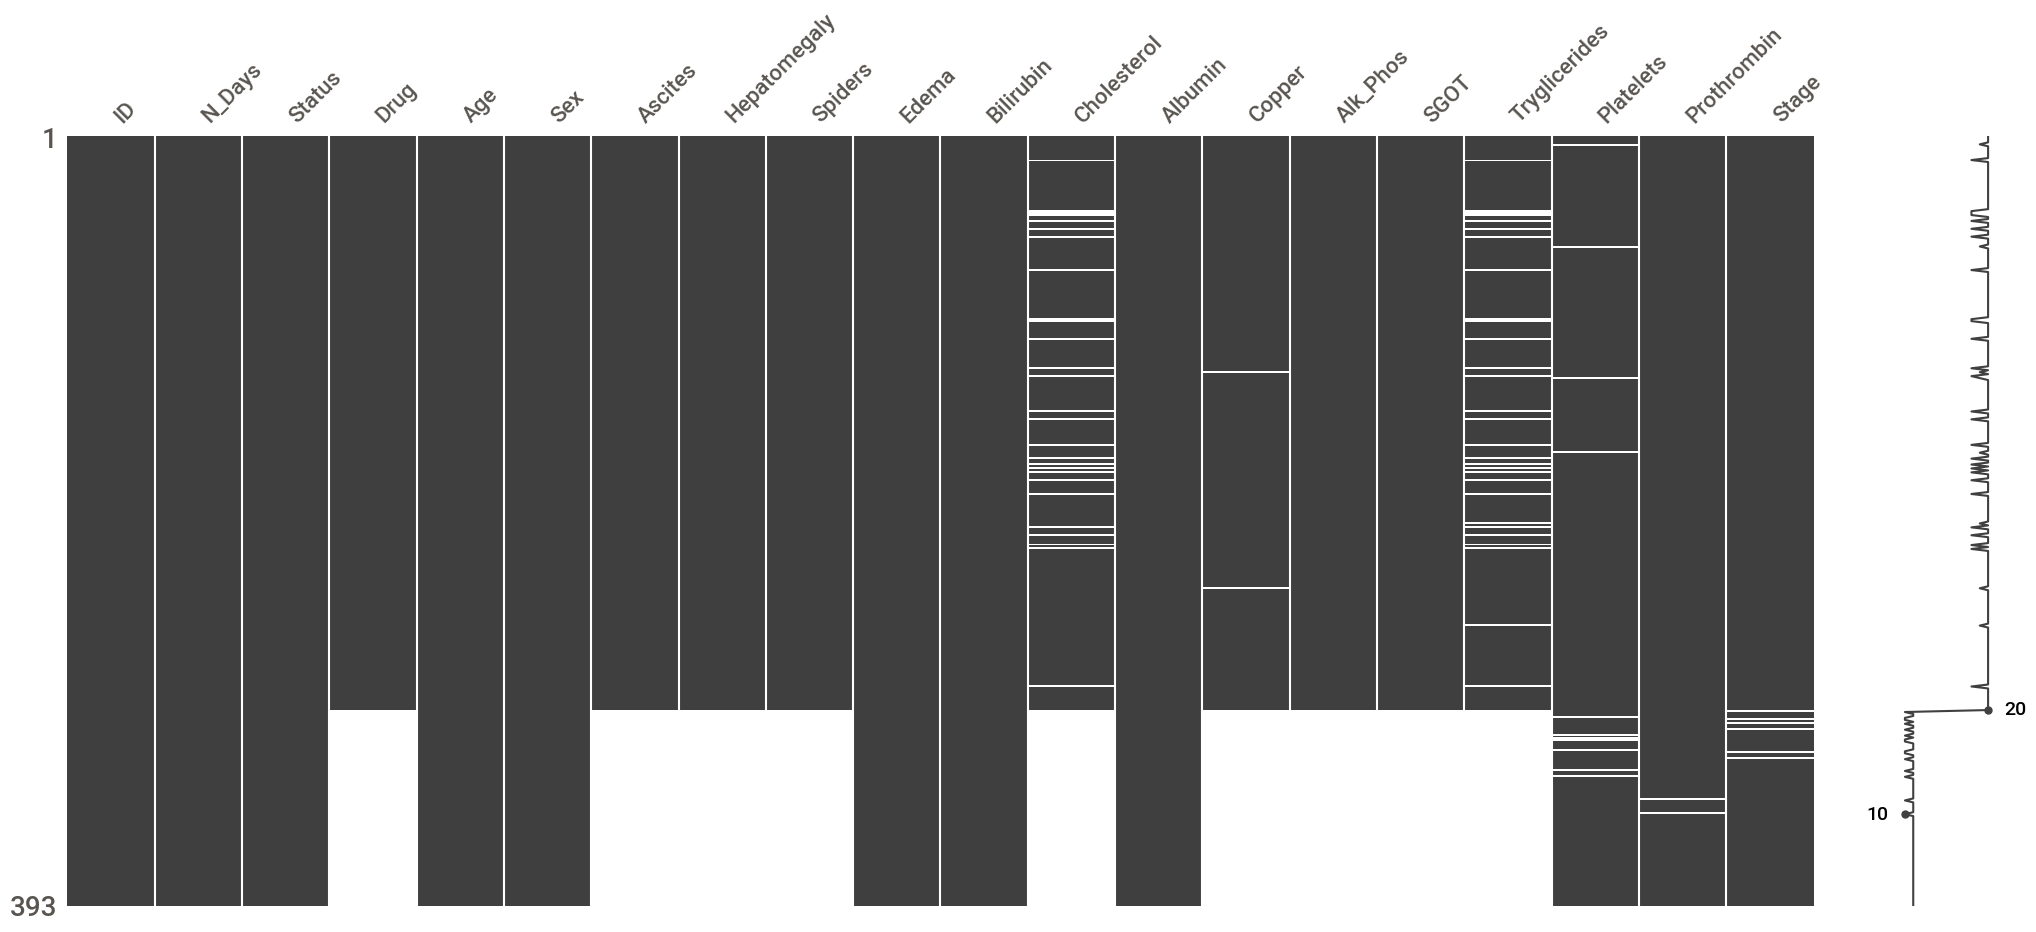

In [6]:
# ==============================================
# Extra EDA
# ==============================================
plot_histogram(df, 'Bilirubin')
plot_boxplot(df, 'Status', 'Bilirubin')
plot_histogram(df, 'Albumin')
plot_boxplot(df, 'Status', 'Albumin')
plot_histogram(df, 'Prothrombin')
plot_correlation_heatmap(df, exclude_cols=['ID', 'D'], title="Correlation Heatmap – Raw Variables")
plot_missing_matrix(df)
plt.show()


# PART 4

# Missing values


In [7]:
# ==============================================
# Section 4.2 – Handle Missing Values
# ==============================================

# Step 1: Display count and percentage of missing values
missing_summary = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_%': missing_percentage
}).sort_values(by='Missing_%', ascending=False)

print("=== Missing Values Summary ===")
print(missing_df)

# Step 2: Fill missing categorical values with 'Unknown'
categorical_missing = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']

for col in categorical_missing:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

# Step 3: Encode categorical variables numerically
df_imputed = df.copy()
label_encoders = {}

for col in categorical_missing:
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col])
    label_encoders[col] = le

# Step 4: Apply Iterative Imputer for numerical variables
numeric_cols = df_imputed.select_dtypes(include=['number']).columns
iterative_imputer = IterativeImputer(random_state=0)
df_imputed[numeric_cols] = iterative_imputer.fit_transform(df_imputed[numeric_cols])

# df_imputed is now free of missing values


=== Missing Values Summary ===
               Missing_Count  Missing_%
Tryglicerides            129  32.824427
Cholesterol              127  32.315522
Copper                   102  25.954198
Drug                     100  25.445293
Ascites                  100  25.445293
Hepatomegaly             100  25.445293
Spiders                  100  25.445293
SGOT                     100  25.445293
Alk_Phos                 100  25.445293
Platelets                 11   2.798982
Stage                      6   1.526718
Prothrombin                2   0.508906
ID                         0   0.000000
Albumin                    0   0.000000
N_Days                     0   0.000000
Edema                      0   0.000000
Sex                        0   0.000000
Age                        0   0.000000
Status                     0   0.000000
Bilirubin                  0   0.000000


In [8]:
# ==============================================
# Section 4.3 – Handle Outliers Using IQR Method
# ==============================================

# Function to remove outliers from a column using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# List of numerical columns to clean outliers
numerical_outlier_cols = ['Cholesterol', 'Copper', 'Tryglicerides',
                          'Platelets', 'Prothrombin', 'Stage', 'Bilirubin']

# Create a copy for outlier removal
df_clean = df_imputed.copy()

# Apply outlier removal for each column
for col in numerical_outlier_cols:
    if col in df_clean.columns:
        df_clean = remove_outliers_iqr(df_clean, col)

# Display summary statistics after outlier removal
print("\n=== Cleaned Data Summary ===")
print(df_clean[numerical_outlier_cols].describe())



=== Cleaned Data Summary ===
       Cholesterol      Copper  Tryglicerides   Platelets  Prothrombin  \
count   260.000000  260.000000     260.000000  260.000000   260.000000   
mean    306.125906   60.305263     103.998469  249.536732    10.486496   
std      76.146284   35.054331      26.219119   85.408721     0.644584   
min     120.000000  -16.636553      44.000000   79.000000     9.000000   
25%     253.000000   35.750000      88.000000  182.750000    10.000000   
50%     298.001948   57.969568     106.500000  247.000000    10.500000   
75%     360.089032   76.000000     118.563132  309.000000    10.900000   
max     578.000000  178.000000     175.000000  493.000000    12.300000   

            Stage   Bilirubin  
count  260.000000  260.000000  
mean     2.900909    1.326923  
std      0.898445    0.898200  
min      1.000000    0.300000  
25%      2.000000    0.700000  
50%      3.000000    1.000000  
75%      4.000000    1.700000  
max      4.000000    4.400000  


In [9]:
# ==============================================
# Save Cleaned Dataset After Preprocessing
# ==============================================
# This step saves the dataset after completing all preprocessing stages:
# Step 4.1 – Removed 'CL' records (Status == 'CL') [if previously done]
# Step 4.2 – Handled missing values:
#              - Categorical columns filled with "Unknown"
#              - Numerical columns imputed using IterativeImputer (predictive)
# Step 4.3 – Removed outliers using IQR method for selected numeric variables
#
# Saving this version ensures that Feature Engineering (Section 4.4)
# is based on a clean, consistent, and fully preprocessed dataset.

df_clean.to_csv("cirrhosis_cleaned.csv", index=False)


In [10]:
# ==============================================
# Section 4.4 – Feature Engineering
# ==============================================

# Load the dataset after cleaning (missing values + outliers already handled)
df = pd.read_csv("cirrhosis_cleaned.csv")

# 1. Create a binary feature for advanced disease stage (Stage 3 or 4)
df['Advanced_Stage'] = df['Stage'].apply(lambda x: 1 if x >= 3 else 0)

# 2. Create a binary feature for high Bilirubin levels (above median)
median_bilirubin = df['Bilirubin'].median()
df['High_Bilirubin'] = df['Bilirubin'].apply(lambda x: 1 if x > median_bilirubin else 0)

# 3. Normalize key clinical numeric features using Min-Max scaling
norm_features = ['Bilirubin', 'SGOT', 'Albumin', 'Copper', 'Alk_Phos', 'Platelets', 'Prothrombin']
scaler = MinMaxScaler()
norm_data = pd.DataFrame(
    scaler.fit_transform(df[norm_features]),
    columns=[f'{col}_norm' for col in norm_features]
)
df = pd.concat([df.reset_index(drop=True), norm_data], axis=1)

# 4. Create composite risk scores (mean of normalized features)
df['Risk_Score_Liver'] = df[['Bilirubin_norm', 'SGOT_norm', 'Albumin_norm']].mean(axis=1)
df['Risk_Score_Blood'] = df[['Copper_norm', 'Platelets_norm', 'Prothrombin_norm']].mean(axis=1)

# 5. Create ratio-based clinical features
df['Bilirubin_to_Albumin'] = df['Bilirubin'] / df['Albumin']
df['SGOT_to_AlkPhos'] = df['SGOT'] / df['Alk_Phos']

# 6. Calculate age in years and create age groups
df['Age_years'] = df['Age'] // 365
df['Age_group'] = pd.cut(
    df['Age_years'],
    bins=[0, 30, 50, 70, 100],
    labels=['Young', 'Middle', 'Senior', 'Old']
)

# 7. Ordinal encoding for Edema (N=0, S=1, Y=2)
edema_map = {'N': 0, 'S': 1, 'Y': 2}
df['Edema_code'] = df['Edema'].map(edema_map)

# 8. Create a binary feature for severe symptoms (both Ascites and Edema are 'Y')
df['Severe_Symptoms'] = ((df['Ascites'] == 'Y') & (df['Edema'] == 'Y')).astype(int)

# 9. FIX: Fill remaining missing values (e.g. from feature engineering)
df = df.fillna(df.median(numeric_only=True))

# 10. Save the final dataset with engineered features and no NaNs
df.to_csv("cirrhosis_cleaned_with_features.csv", index=False)


In [11]:
# ==============================================
# Section 4.1.2 – Exploratory Data Analysis (EDA) with Sweetviz(Updated Data)
# ==============================================
df = pd.read_csv("cirrhosis_cleaned_with_features.csv")

# Create a report using the cleaned dataset
report = sv.analyze(df)

# Save the report to an HTML file
report.show_html("sweetviz_report_Updated.html", open_browser=True)

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report_Updated.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


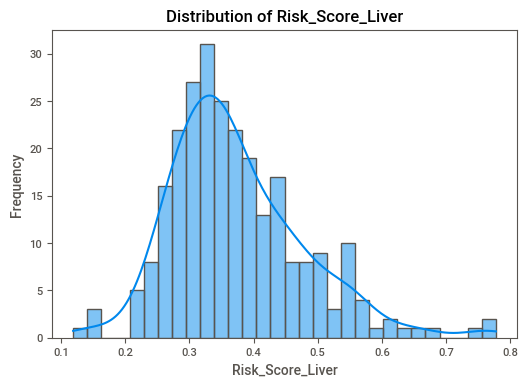

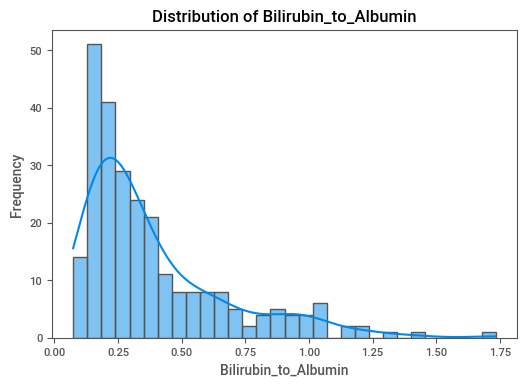

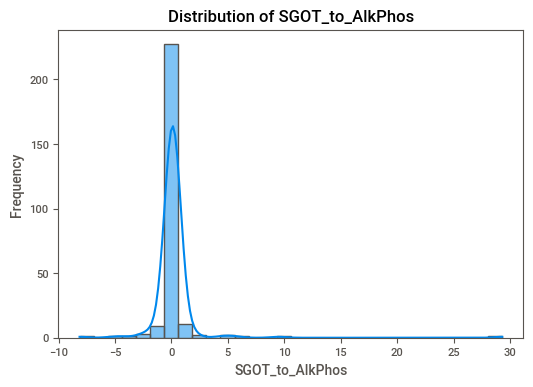

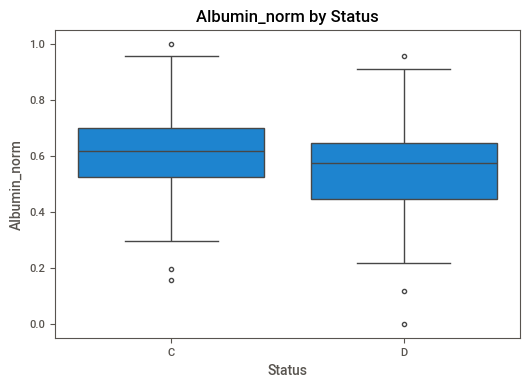

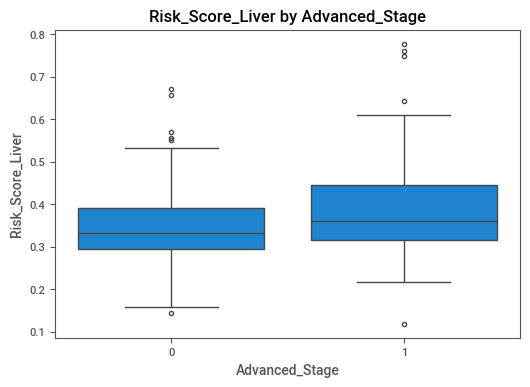

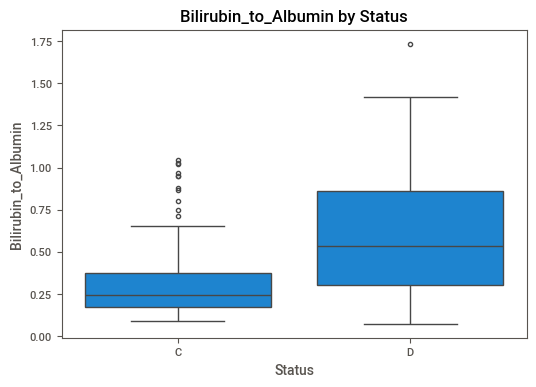

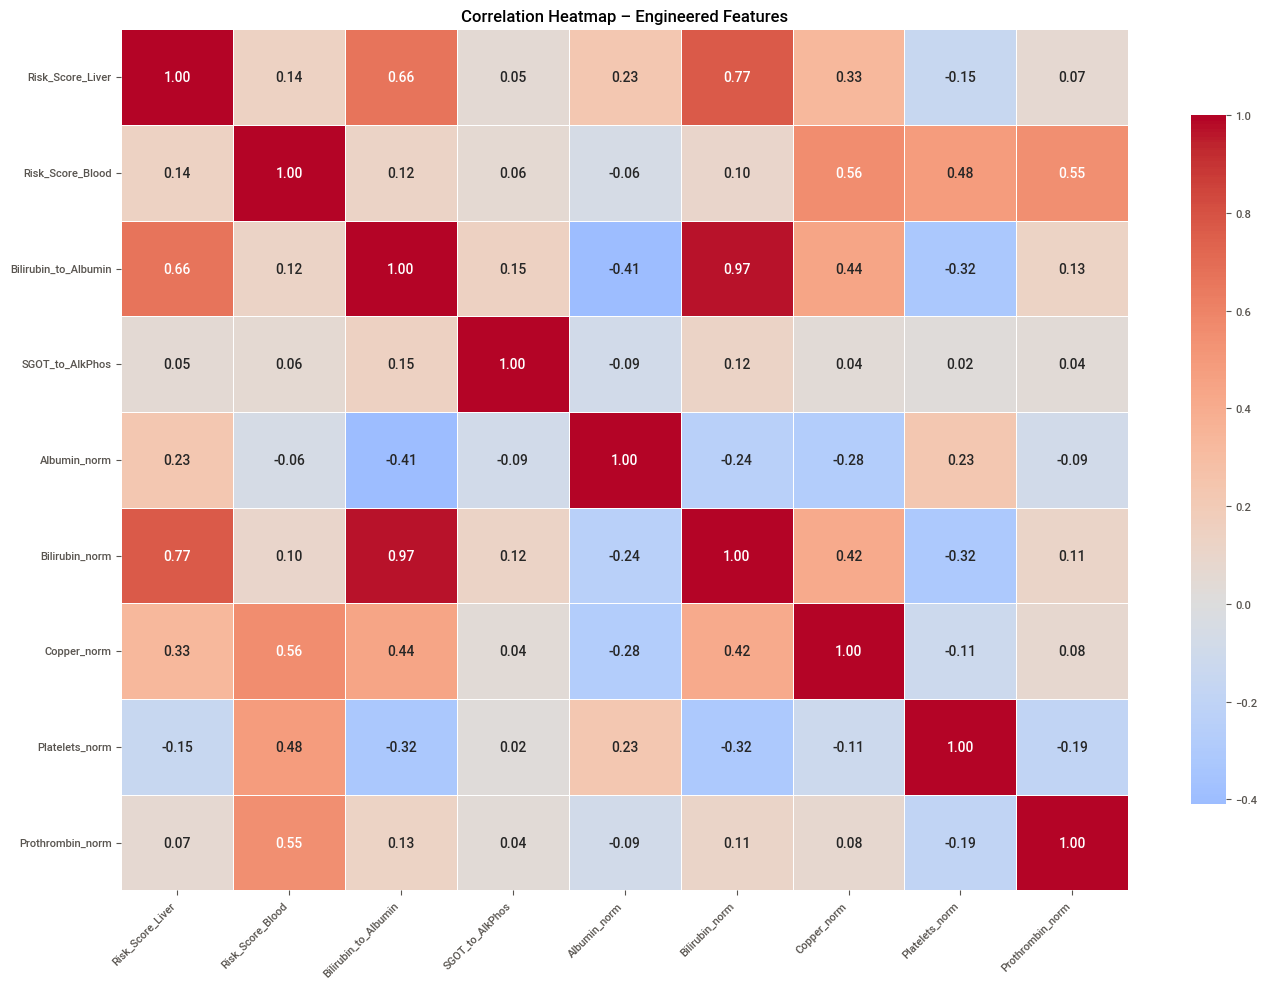

In [12]:
# ==============================================
# Extra EDA
# ==============================================
plot_histogram(df, 'Risk_Score_Liver')
plot_histogram(df, 'Bilirubin_to_Albumin')
plot_histogram(df, 'SGOT_to_AlkPhos')
plot_boxplot(df, 'Status', 'Albumin_norm')
plot_boxplot(df, 'Advanced_Stage', 'Risk_Score_Liver')
plot_boxplot(df, 'Status', 'Bilirubin_to_Albumin')
plot_correlation_heatmap(df, columns=[
    'Risk_Score_Liver', 'Risk_Score_Blood', 'Bilirubin_to_Albumin',
    'SGOT_to_AlkPhos', 'Albumin_norm', 'Bilirubin_norm',
    'Copper_norm', 'Platelets_norm', 'Prothrombin_norm'
], title="Correlation Heatmap – Engineered Features")


# Test the balance before part 5

In [13]:
### Section 4.5 – Evaluation of the Need for Class Balancing (SMOTE)
'''
At this stage, we evaluated whether class balancing was necessary for our classification task by applying SMOTE (Synthetic Minority Over-sampling Technique).
To assess its impact, we trained a simple logistic regression model twice: once on the original training data, and once after applying SMOTE to balance the class distribution.
The comparison showed an improvement in the recall for class "D" (Deceased) from 0.56 to 0.65, alongside an increase in the F1-score. The overall accuracy remained stable at 0.73, suggesting that SMOTE enhanced the model’s ability to detect critical cases without compromising general performance.
'''

# Load cleaned dataset with engineered features
df = pd.read_csv("cirrhosis_cleaned_with_features.csv")
df = df.dropna()
df = df[df['Status'] != 'CL']
df['Status'] = df['Status'].map({'C': 0, 'D': 1})

# Define features and target
X = df.drop(columns=['Status', 'ID'])
y = df['Status']
X = pd.get_dummies(X, drop_first=True)

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.3, random_state=42
)

# Train logistic regression without SMOTE
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Without SMOTE:")
print(classification_report(y_test, y_pred))

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train logistic regression after applying SMOTE
model_smote = LogisticRegression(max_iter=2000)
model_smote.fit(X_resampled, y_resampled)
y_pred_smote = model_smote.predict(X_test)

print("With SMOTE:")
print(classification_report(y_test, y_pred_smote))


Without SMOTE:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        58
           1       0.56      0.25      0.34        20

    accuracy                           0.76        78
   macro avg       0.67      0.59      0.60        78
weighted avg       0.72      0.76      0.72        78

With SMOTE:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        58
           1       0.68      0.65      0.67        20

    accuracy                           0.83        78
   macro avg       0.78      0.77      0.78        78
weighted avg       0.83      0.83      0.83        78



**Conclusion:** Based on these findings, incorporating SMOTE during the training of predictive models is strongly recommended, especially when recall for the minority class is a clinical priority.

After normalizing the features, logistic regression was rerun with and without SMOTE. The results show a substantial improvement in the model’s ability to detect the minority class (deceased):  
Recall for class 1 increased from 0.25 to 0.65, F1-score improved from 0.34 to 0.67, and overall accuracy rose from 0.76 to 0.83.

These findings confirm that applying SMOTE is highly beneficial in this dataset, even though the original class distribution was only moderately imbalanced.  
Improving recall for deceased patients is especially critical in clinical applications, where failing to identify such cases can have serious consequences.


# PART 5

In [14]:
# ------------------------------------------------
# 5.1 – Load the prepared dataset and define target
# ------------------------------------------------
df = pd.read_csv("cirrhosis_cleaned_with_features.csv")  # includes engineered features
df_model = df.copy()
df_model['target'] = df_model['Status'].map({'C': 0, 'D': 1})

In [15]:
# ------------------------------------------------
# Check for missing values
# ------------------------------------------------

missing_values = df_model.isnull().sum()
print("Missing values in df_model:")
print(missing_values[missing_values > 0])

# Check shape
print(f"\nDataset shape: {df_model.shape}")

# Check target values
print("\nUnique values in target column:")
print(df_model['target'].value_counts())


Missing values in df_model:
Series([], dtype: int64)

Dataset shape: (260, 38)

Unique values in target column:
target
0    192
1     68
Name: count, dtype: int64


In [16]:
# ------------------------------------------------
# 5.2 – Check if the target variable is balanced
# ------------------------------------------------
class_counts = df_model['target'].value_counts(normalize=True)
print("Target class distribution (proportions):")
print(class_counts)

Target class distribution (proportions):
target
0    0.738462
1    0.261538
Name: proportion, dtype: float64


In [17]:
# ------------------------------------------------
# 5.3 – Select features and handle missing values
# ------------------------------------------------

features = ['Advanced_Stage', 'High_Bilirubin', 'Risk_Score_Liver',
            'Risk_Score_Blood', 'Bilirubin_to_Albumin', 'SGOT_to_AlkPhos',
            'Edema_code', 'Severe_Symptoms', 'Age_years']

X = df_model[features]
y = df_model['target']

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)


In [18]:
# ------------------------------------------------
# 5.4 – Split data into training and test sets
# ------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)


In [19]:
# === SMOTE to balance the training set ===


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [20]:
# ------------------------------------------------
# 5.5 – Define and train predictive models
# ------------------------------------------------

# === Normalize features for logistic regression ===
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False,
                             eval_metric='logloss', random_state=42)
}

In [21]:
# ------------------------------------------------
# 5.6 – Evaluate models using Accuracy, AUC, and F1
# ------------------------------------------------
# Initialize results list to collect evaluation metrics
results = []

# Loop over all defined models
for name, model in models.items():
    print(f"\nResults for {name}:")

    # Train logistic regression on scaled data; others on resampled data
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train_resampled)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train_resampled, y_train_resampled)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate model using Accuracy, AUC, and F1-score
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)

    # Display classification report
    print(classification_report(y_test, y_pred))

    # Store results for comparison
    results.append({
        'Model': name,
        'Accuracy': round(acc, 3),
        'AUC': round(auc, 3),
        'F1 Score': round(f1, 3)
    })

# Create a results DataFrame sorted by AUC
results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print(results_df)

# Save results to CSV
results_df.to_csv("model_results.csv", index=False)



Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        38
           1       0.57      0.57      0.57        14

    accuracy                           0.77        52
   macro avg       0.71      0.71      0.71        52
weighted avg       0.77      0.77      0.77        52


Results for Random Forest:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        38
           1       0.40      0.29      0.33        14

    accuracy                           0.69        52
   macro avg       0.58      0.56      0.57        52
weighted avg       0.66      0.69      0.67        52


Results for XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        38
           1       0.50      0.43      0.46        14

    accuracy                           0.73        52
   macro avg       0.65      0.64      0.64 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:26:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



==== Logistic Regression ====
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        38
           1       0.57      0.57      0.57        14

    accuracy                           0.77        52
   macro avg       0.71      0.71      0.71        52
weighted avg       0.77      0.77      0.77        52

Confusion Matrix:
[[32  6]
 [ 6  8]]


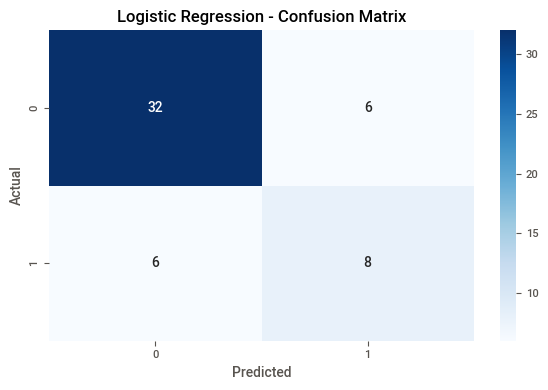


==== Random Forest ====
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        38
           1       0.40      0.29      0.33        14

    accuracy                           0.69        52
   macro avg       0.58      0.56      0.57        52
weighted avg       0.66      0.69      0.67        52

Confusion Matrix:
[[32  6]
 [10  4]]


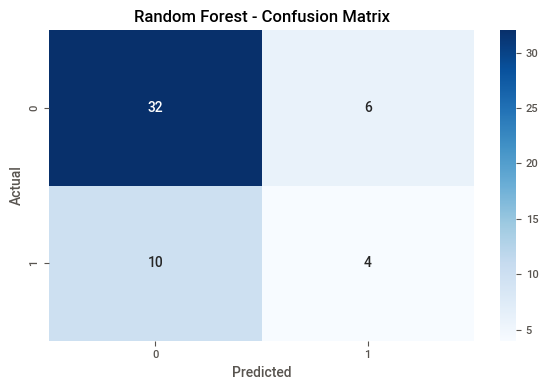


==== XGBoost ====
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        38
           1       0.50      0.43      0.46        14

    accuracy                           0.73        52
   macro avg       0.65      0.64      0.64        52
weighted avg       0.72      0.73      0.72        52

Confusion Matrix:
[[32  6]
 [ 8  6]]


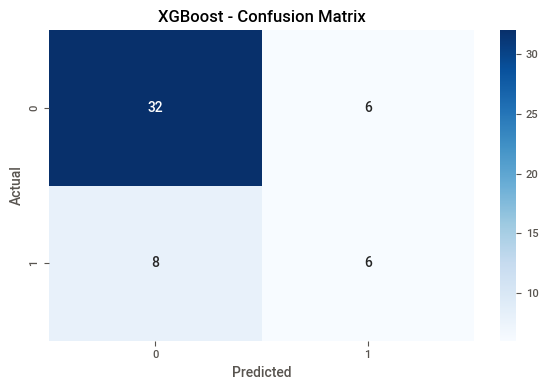

In [22]:
# ------------------------------------------------
# Save classification reports and confusion matrices
# ------------------------------------------------
with open("model_reports.txt", "w") as f:
    for name, model in models.items():
        f.write(f"\n==== {name} ====\n")
        print(f"\n==== {name} ====")

        # Use correct test set depending on model
        if name == 'Logistic Regression':
            y_pred = model.predict(X_test_scaled)
        else:
            y_pred = model.predict(X_test)

        # === Classification Report ===
        report = classification_report(y_test, y_pred)
        f.write("Classification Report:\n")
        f.write(report + "\n")
        print(report)

        # === Confusion Matrix ===
        cm = confusion_matrix(y_test, y_pred)
        f.write("Confusion Matrix:\n")
        f.write(str(cm) + "\n")
        print("Confusion Matrix:")
        print(cm)

        # === Save Confusion Matrix as Plot ===
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig(f"{name.replace(' ', '_')}_confusion_matrix.png")
        plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:35:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


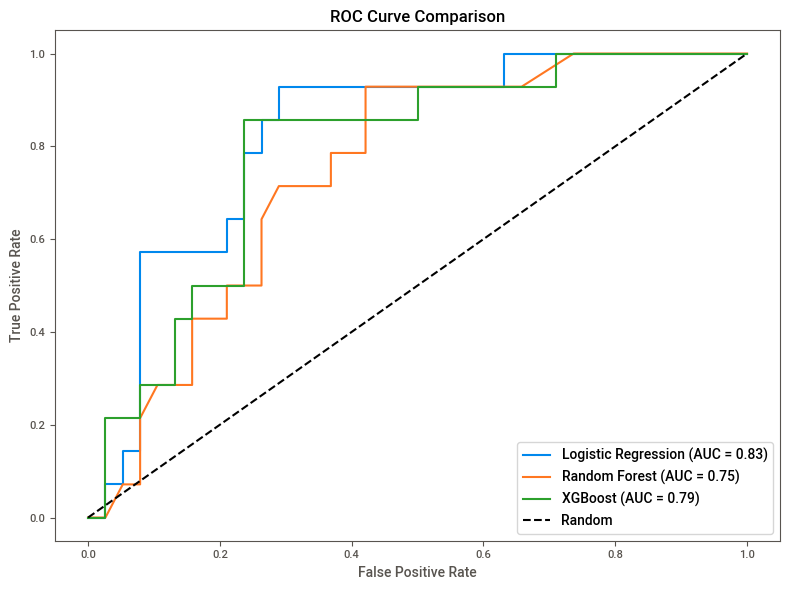

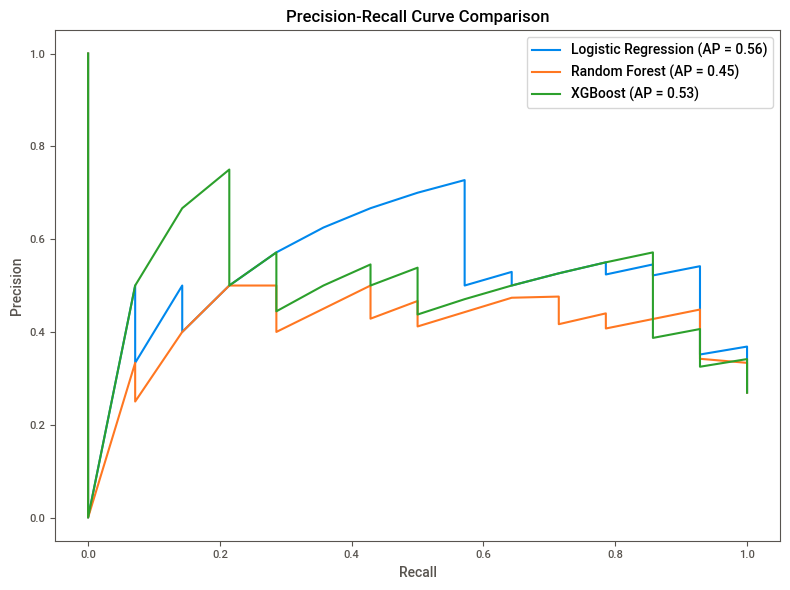

In [24]:
# ------------------------------------------------
# ROC & Precision-Recall Curve Comparison for All Models
# ------------------------------------------------
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Fit models before plotting
trained_models = {}

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train_resampled)
        trained_models[name] = (model, X_test_scaled)
    else:
        model.fit(X_train_resampled, y_train_resampled)
        trained_models[name] = (model, X_test)

# Create plots
fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
fig_pr, ax_pr = plt.subplots(figsize=(8, 6))

# Plot curves
for name, (model, X_input_test) in trained_models.items():
    y_scores = model.predict_proba(X_input_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = average_precision_score(y_test, y_scores)
    ax_pr.plot(recall, precision, label=f'{name} (AP = {pr_auc:.2f})')

# Finalize and save ROC
ax_roc.plot([0, 1], [0, 1], 'k--', label='Random')
ax_roc.set_title("ROC Curve Comparison")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend(loc="lower right")
fig_roc.tight_layout()
fig_roc.savefig("ROC_curve_comparison.png", dpi=300)

# Finalize and save PR
ax_pr.set_title("Precision-Recall Curve Comparison")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.legend(loc="upper right")
fig_pr.tight_layout()
fig_pr.savefig("PR_curve_comparison.png", dpi=300)

plt.show()
